<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S7/EVA4_Session_7_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S7 _Assignment 7_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **CIFAR10** |
  | _Max. number of epochs_| **NA** |
  | _Max. number of parameters_| **1M** |


# Implementation

## Initialization

### Mounting google drive to save results

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import and install all required libraries

In [0]:
!pip install torchsummary
!pip install torchviz
!pip install receptivefield>=0.5.0

import datetime
import glob

import numpy as np
import pandas as pd
import cv2

from __future__ import print_function        # Import for print statement
import torch                                 # Import pytorch library
import torch.nn as nn                        # Import neural net module from pytorch
import torch.nn.functional as F              # Import functional interface from pytorch
import torch.optim as optim                  # Import optimizer module from pytorch

import torchvision
from torchvision import datasets, transforms # Import datasets and augmentation functionality from vision module within pytorch
from torchsummary import summary             # Import summary with pytorch
from torchviz import make_dot

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR

In [0]:
use_cuda = torch.cuda.is_available()                  # Check cuda avaliability

In [0]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

## Load MNIST Dataset

### Initialize _transforms_, _dataset_ & _dataloader_

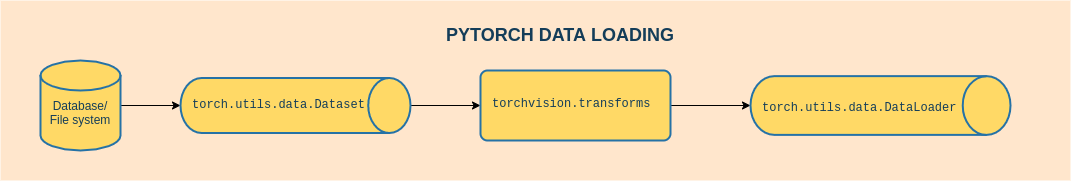

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

In [0]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 64

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


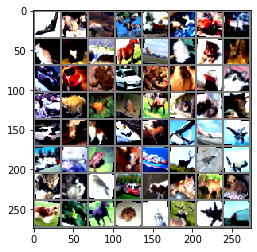

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


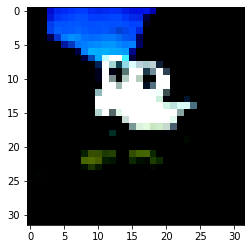

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.imshow(images[0].numpy().swapaxes(0, 2).swapaxes(0, 1))
plt.show()

## Experiment

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        ##############################################################################################################
        # CONVOLUTION BLOCK 1 - DILATED CONVOLUTION
        ##############################################################################################################
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # TRANSITION BLOCK 1
        ##############################################################################################################
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # CONVOLUTION BLOCK 2
        ##############################################################################################################
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(2, 2), bias=False, dilation=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # TRANSITION BLOCK 2
        ##############################################################################################################
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # CONVOLUTION BLOCK 3 - DEPTH-WISE SEPERABLE
        ##############################################################################################################
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), groups=256, bias=False),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # TRANSITION BLOCK 3
        ##############################################################################################################
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # CONVOLUTION BLOCK 4
        ##############################################################################################################
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), groups=256, bias=False),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        ##############################################################################################################
        # OUTPUT BLOCK
        ##############################################################################################################
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(0.05)
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(1, 1), padding=(0, 0), bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool3(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

###Summary

####Textual summary

In [0]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPU
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 18, 18]           8,192
       BatchNorm2d-6          [-1, 128, 18, 18]             256
              ReLU-7          [-1, 128, 18, 18]               0
            Conv2d-8          [-1, 128, 18, 18]         147,456
       BatchNorm2d-9          [-1, 128, 18, 18]             256
             ReLU-10          [-1, 128, 18, 18]               0
        MaxPool2d-11            [-1, 128, 9, 9]               0
           Conv2d-12          [-1, 256, 11, 11]          32,768
      BatchNorm2d-13          [-1, 256, 11, 11]             512
             ReLU-14          [-1, 256,

####Graphical summary

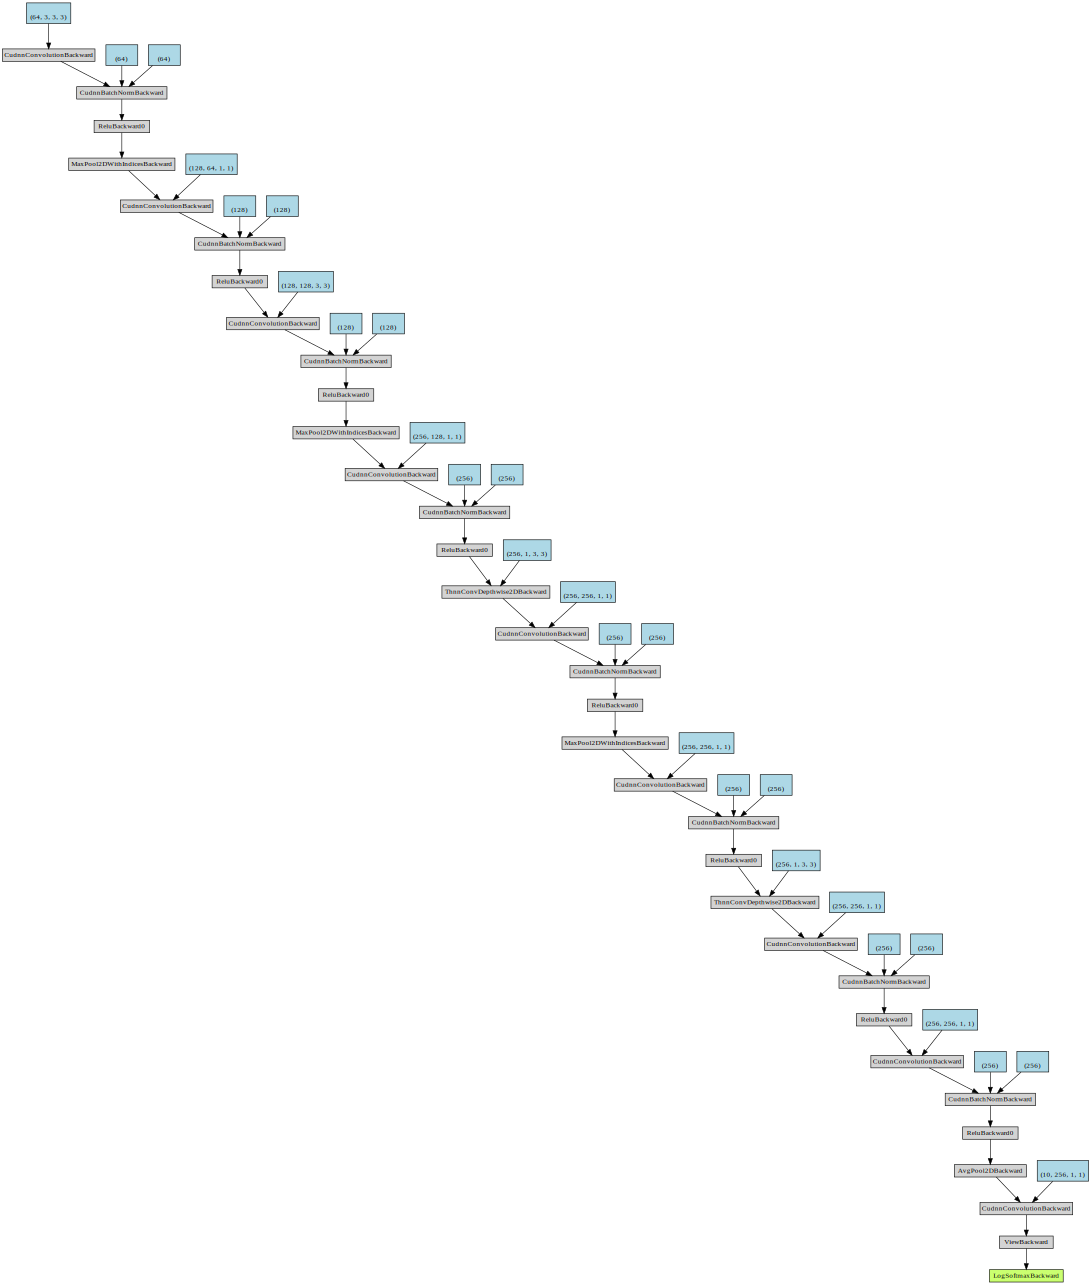

In [0]:
random_input = torch.randn(1, 3, 32, 32).cuda() if use_cuda else torch.randn(1, 3, 32, 32) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'model_architecture')
dot_graph

### Training

#### Training routine

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer, regularization=None, weight_decay=0.01):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)

    for batch_idx, (data, target) in enumerate(pbar):
        
        # Move data to cpu/gpu based on input
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Loss computation
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        

        # Regularization
        if regularization == 'L1' or regularization == 'L1 and L2':
          l1_loss = nn.L1Loss(reduction='sum')
          regularization_loss = 0
          for param in model.parameters():
            regularization_loss += l1_loss(param, target=torch.zeros_like(param))
          train_loss += weight_decay * regularization_loss # regularization loss
        
        # Predictions
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Backward pass
        batch_loss.backward()
        
        # Gradient descent
        optimizer.step()

        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.2f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

#### Testing routine

In [0]:
def test(model, device, test_loader, epoch, writer, regularization=None, weight_decay=0.01):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):

            # Move data to cpu/gpu based on input
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Loss computation
            batch_loss = F.nll_loss(output, target, reduction='sum').item()
            test_loss += batch_loss

            # Predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Logging - updating progress bar and summary writer
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.2f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

### Execution

In [0]:
def optimize(model, epochs=40, momentum=0.9, lr=0.01, regularization=None, weight_decay=0.01, experiment_name='experiment_name_1'):
  now = datetime.datetime.now()
  prefix = now.strftime('%m-%d-%y %H:%M:%S')

  train_dir_suffix = f'/content/drive/My Drive/log_cifar_s7/run_train_{experiment_name}'
  test_dir_suffix = f'/content/drive/My Drive/log_cifar_s7/run_test_{experiment_name}'

  train_dir = f'{train_dir_suffix}_{prefix}'
  test_dir = f'{test_dir_suffix}_{prefix}'

  train_writer = SummaryWriter(train_dir)
  test_writer = SummaryWriter(test_dir)

  if regularization == 'L2' or regularization == 'L1 and L2':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  else:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

  scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

  for epoch in range(0, epochs):
      train(model, device, train_loader, optimizer, epoch, train_writer, regularization, weight_decay)
      test(model, device, test_loader, epoch, test_writer, regularization, weight_decay)
      scheduler.step()

In [0]:
# for regularization in [None, 'L1', 'L2', 'L1 and L2']:
# for weight_decay in [1e-1, 1e-3, 1e-6]:

In [0]:
regularization = 'L2'
weight_decay = 1e-6
experiment = f's7_{regularization if regularization else "no"}_reg_{weight_decay:1.0e}'
model = Net().to(device)
if hasattr(tqdm, '_instances'):
  tqdm._instances.clear()
lr = 0.1
epochs = 45
momentum = 0.9
optimize(model, epochs, momentum, lr, regularization, weight_decay, experiment)

TRAIN : epoch=0 train_loss=0.02342 correct/total=22403/50000 accuracy=44.81: 100%|██████████| 782/782 [00:31<00:00, 24.48it/s]
TEST :  epoch=0 test_loss=1.38828 correct/total=5285/10000 accuracy=52.85: 100%|██████████| 157/157 [00:02<00:00, 60.39it/s]
TRAIN : epoch=1 train_loss=0.01771 correct/total=29695/50000 accuracy=59.39: 100%|██████████| 782/782 [00:31<00:00, 24.85it/s]
TEST :  epoch=1 test_loss=1.02643 correct/total=6403/10000 accuracy=64.03: 100%|██████████| 157/157 [00:02<00:00, 61.16it/s]
TRAIN : epoch=2 train_loss=0.01531 correct/total=32636/50000 accuracy=65.27: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s]
TEST :  epoch=2 test_loss=0.91030 correct/total=6756/10000 accuracy=67.56: 100%|██████████| 157/157 [00:02<00:00, 71.59it/s]
TRAIN : epoch=3 train_loss=0.01366 correct/total=34701/50000 accuracy=69.40: 100%|██████████| 782/782 [00:31<00:00, 24.81it/s]
TEST :  epoch=3 test_loss=1.01537 correct/total=6740/10000 accuracy=67.40: 100%|██████████| 157/157 [00:02<00:00, 75.

# Outputs

## Loss and accuracy

In [0]:
def get_test_train_logs(experiment_name):
  train_dir_suffix = f'/content/drive/My Drive/log_cifar_s7/run_train_{experiment_name}'
  test_dir_suffix = f'/content/drive/My Drive/log_cifar_s7/run_test_{experiment_name}'

  train_1 = glob.glob(f'{train_dir_suffix}_*/events.out.tfevents.*')[-1]
  test_1 = glob.glob(f'{test_dir_suffix}_*/events.out.tfevents.*')[-1]

  experiment_data = {experiment_name: (train_1, test_1)}

  for experiment, (train, test) in experiment_data.items():
    train_data = {}
    test_data = {}
    for e in tf.compat.v1.train.summary_iterator(train):
        for v in e.summary.value:
            if v.tag not in train_data:
                train_data[v.tag] = []
            train_data[v.tag].append(v.simple_value)
    for e in tf.compat.v1.train.summary_iterator(test):
          for v in e.summary.value:
              if v.tag not in test_data:
                  test_data[v.tag] = []
              test_data[v.tag].append(v.simple_value)
  
  return train_data, test_data

In [0]:
experiments = []
for regularization in ['L2']:
  for weight_decay in [1e-6]:
    experiment = f's6_{regularization if regularization else "no"}_reg_{weight_decay:1.0e}'
    experiments.append(experiment)

In [0]:
summary = {}
for experiment in experiments:
  summary[experiment] = {}
  train_data, test_data = get_test_train_logs(experiment)
  summary[experiment]['train'] = train_data
  summary[experiment]['test'] = test_data

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


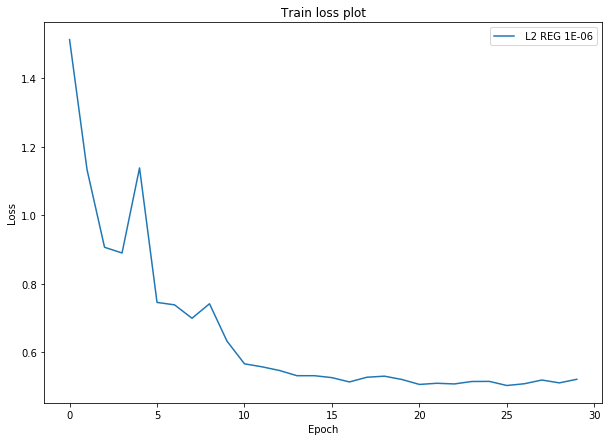

In [0]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

legends = []

axs.set_title(f'Train loss plot')

for experiment in experiments:
  axs.plot(summary[experiment]['test']['loss'])
  axs.set_ylabel('Loss')
  axs.set_xlabel('Epoch')
  legends.append(experiment.replace('s6', '').replace('_', ' ').upper())

axs.legend(legends, loc='best')

plt.savefig('/content/drive/My Drive/log_mnist_s6/test-loss-curve.jpg')
plt.show()

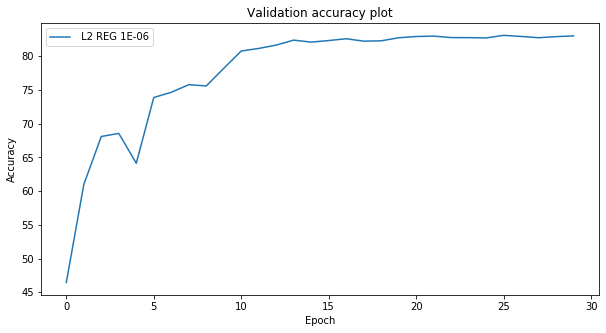

In [0]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.set_title(f'Validation accuracy plot')

legends = []

for experiment in experiments:
  axs.plot(summary[experiment]['test']['accuracy'])
  axs.set_ylabel('Accuracy')
  axs.set_xlabel('Epoch')
  legends.append(experiment.replace('s6', '').replace('_', ' ').upper())

axs.legend(legends, loc='best')

plt.savefig('/content/drive/My Drive/log_mnist_s6/validation-accuracy-curve.jpg')
plt.show()

## Get mis-classified

In [0]:
def get_mis_classified(model, no_of_images=25):
  train_loader_iterator = iter(train_loader)
  fail_count = 0
  failed_samples = []
  while fail_count < no_of_images:
    data, target = train_loader_iterator.next()
    data, target = data.to(device), target.to(device)

    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)
    failed_index = ~pred.eq(target.view_as(pred)).squeeze()

    failed_data = data[failed_index]
    failed_target = target[failed_index]
    failed_prediction = pred[failed_index]
    
    batch_fail_count = failed_data.size(dim=0)
    fail_count += batch_fail_count

    for count in range(batch_fail_count):
      failed_sample = {
          'data': failed_data[count].view(3, 32, 32).cpu().numpy().swapaxes(0, 2).swapaxes(0, 1),
          'target': failed_target[count],
          'prediction': failed_prediction[count].item()
      }

      failed_samples.append(failed_sample)

  return failed_samples

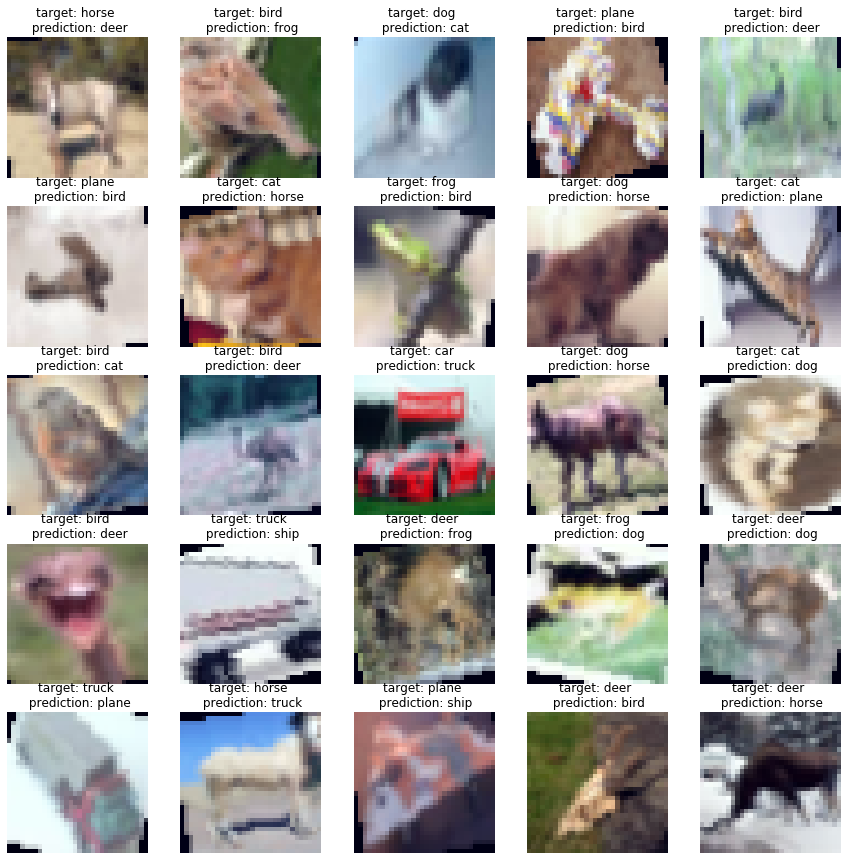

In [0]:
figure = plt.figure(figsize=(15, 15))
num_of_images = 25
failed_samples = get_mis_classified(model, num_of_images)
for index in range(1, num_of_images + 1):
    ax = plt.subplot(5, 5, index)
    plt.axis('off')
    image = failed_samples[index - 1]['data']
    image = (image - image.min()) / (image.max() - image.min())
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    ax.set_title(f"target: {classes[failed_samples[index - 1]['target']]} \n prediction: {classes[failed_samples[index - 1]['prediction']]}")
plt.savefig('/content/drive/My Drive/log_mnist_s6/failed-l1.jpg')

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **88.62** |
| _Best test accuracy_| **86.05** |
| _Best epoch number_| **45** |
| _Parameter count_ | **462,656** |